# Rotating Gaussian bump - network stability

* What do the network weights need to look like to have continually stable recurrent activity?

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
def wrap_half_period(x: torch.Tensor, period: int):
	return (x + period//2) % period - period//2

def circ_norm_unnormalised(x: torch.Tensor, mean: torch.Tensor, stdev: float, wrap: int):
	return torch.exp(-wrap_half_period(x - mean, wrap)**2 / 2/stdev**2)

def get_biased_gaussian_weight_matrix(neurons: int, bias: float, stdev: float):
	n_to, n_from = torch.meshgrid(torch.arange(neurons),torch.arange(neurons))
	return circ_norm_unnormalised(n_to, (n_from - bias) % neurons, stdev, neurons)

def get_derivative_gaussian_weight_matrix(neurons: int, stdev: float):
	n_to, n_from = torch.meshgrid(torch.arange(neurons),torch.arange(neurons))
	x_wrapped = -wrap_half_period(n_to - (n_from % num_neurons), neurons)
	gaussian_derivative = x_wrapped*torch.exp(-x_wrapped**2 / 2/stdev**2)
	return gaussian_derivative / gaussian_derivative.max()

def get_rotating_gaussian(time: int, neurons: int, bump_speed: int, stdev: float):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(neurons))
	return circ_norm_unnormalised(x, (t*bump_speed) % neurons, stdev, neurons)

Create the ideal weight matrix for the network

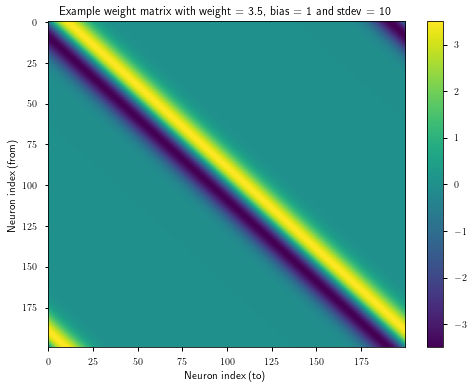

In [3]:
num_neurons = 200
sigma = num_neurons//20
bump_speed = 1
inhibition_weight = -0
weight_range = torch.arange(1.5,3.6,0.25).__reversed__()

scale_max_min = lambda matrix, max, min: (max - min)*matrix + min

def get_weight_matrix(weight: float): # this matrix is now nonnegative because inhibition is separate
	weight_matrix = scale_max_min(get_derivative_gaussian_weight_matrix(num_neurons, sigma), weight-inhibition_weight, 0)
	weight_matrix -= torch.diag(torch.diag(weight_matrix))
	return weight_matrix

	# weight_matrix = scale_max_min(get_biased_gaussian_derivative_weight_matrix(num_neurons, bump_speed, sigma*5), weight, -weight)

	# assym
	# weight_matrix = scale_max_min(get_linear_weight_matrix(num_neurons, bump_speed), weight-inhibition_weight, 0)
	# weight_matrix -= torch.diag(torch.diag(weight_matrix))
	# w = get_biased_gaussian_weight_matrix(num_neurons, 0, num_neurons//30)[0,:]
	# w2 = np.convolve(np.convolve(w,w,'same'), kernel(delta_t),'same')[:-1]
	# return scale_max_min(roll_tensor_rows(torch.tile(torch.tensor(w2),(num_neurons,1)), torch.arange(num_neurons) - num_neurons//2), weight, -weight)

weight_matrix = get_weight_matrix(weight_range[0])

plt.imshow(weight_matrix)
plt.axis('auto')
plt.title(f'Example weight matrix with weight = {weight_range[0]}, bias = {bump_speed} and stdev = {sigma}')
plt.ylabel('Neuron index (from)')
plt.xlabel('Neuron index (to)')
plt.colorbar()
plt.show()

Create the network of LIF neurons and simulate it with the ideal weight matrix. Reduce the magnitude of the weights over time to see when the firing stops

In [4]:
time = 1000
network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

recurrent_connection = Connection(
    source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=0,
	gamma = 0,
	wmin=0,
    w=get_weight_matrix(weight_range[0]),
)
network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')
# inhibitory_connection = Connection(
# 	source=lif_layer,
#     target=lif_layer,
# 	update_rule = HomeostaticSTDP,
# 	nu=0,
# 	gamma = 0,
#     w = inhibition_weight * torch.ones((lif_layer.n,lif_layer.n)),
# )
# # need to patch bindsnet so this works - otherwise connection gets overwritten
# network.add_connection(connection=inhibitory_connection, source='LIF', target='LIF')

# Create and add monitors for spikes and voltages
monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=(len(weight_range))*time)
network.add_monitor(monitor=monitor, name='LIF_monitor')

# Simulate network
# inputs = 4*get_rotating_gaussian(time, num_neurons, bump_speed, num_neurons//10)
inputs= torch.zeros((time,1,num_neurons))
inputs[0:10,:,0:3] = 20 # start some neurons firing to initiate the network
# reduce the weights in the connection matrix and see when activity no longer persists
network.run(inputs = {'LIF': inputs}, time=time, progress_bar=True)
for weight in weight_range[1:]:
	recurrent_connection.w.data = get_weight_matrix(weight)
	network.run(inputs = {}, time=time, progress_bar=True)

# Retrieve data from monitors for analysis
spikes = monitor.get('s')
voltages = monitor.get('v')
rates = monitor.get('r')

Network spiking - reduces as the input decreases, but dies after the weight drops below 3

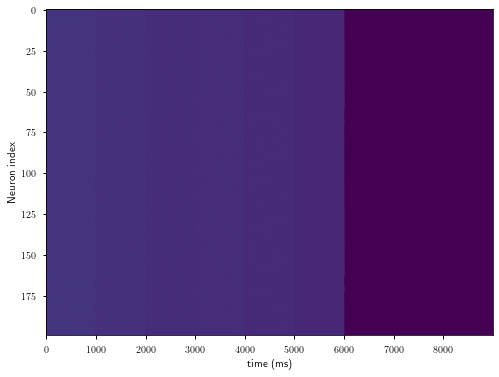

In [5]:
plt.imshow(spikes.squeeze().T)
plt.xlabel('time (ms)')
plt.ylabel('Neuron index')
plt.axis('auto')
plt.show()

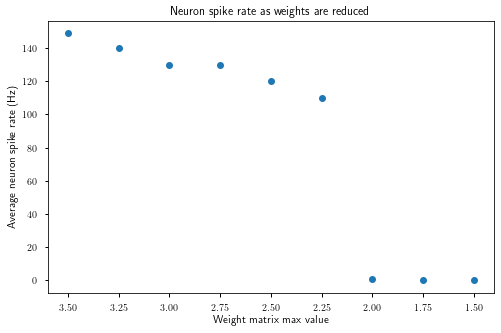

In [6]:
plt.figure(figsize=(8,5))
plt.plot(weight_range, [spike_window.sum()/num_neurons for spike_window in spikes.split(1000,dim=0)], 'o')
plt.xlabel('Weight matrix max value')
plt.ylabel('Average neuron spike rate (Hz)')
plt.title('Neuron spike rate as weights are reduced')
plt.gca().invert_xaxis()
plt.savefig('plots/stable-activity-weights-gaussian.pdf')
plt.show()